In [915]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [916]:
filepath = '/kaggle/input/stock-time-series-20050101-to-20171231/AMZN_2006-01-01_to_2018-01-01.csv'
filepath = 'C:/Users/sulab/Downloads/AMZN_2006-01-01_to_2018-01-01.csv'
filepath = 'AABA_2006-01-01_to_2018-01-01.csv'
# filepath = 'GOOGL_2006-01-01_to_2018-01-01.csv'
# filepath = 'TSMC34.SA.csv'
# filename = 'OXY.csv'
# filepath = '9110.TW.csv'
filepath = '2330.TW.csv' #台積電
# filepath = '2206.TW.csv' #三陽工業






data = pd.read_csv(filepath)
# data = data.sort_values('Date')
# data.head()

In [917]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-06-08,539.0,545.0,538.0,544.0,532.003967,18835521
1,2022-06-09,538.0,542.0,537.0,541.0,529.070068,16338602
2,2022-06-10,530.0,533.0,529.0,530.0,518.312622,21357130
3,2022-06-13,518.0,519.0,515.0,516.0,504.621338,32854092
4,2022-06-14,507.0,514.0,507.0,513.0,501.687531,36304444
...,...,...,...,...,...,...,...
240,2023-06-02,559.0,564.0,557.0,562.0,562.000000,30206141
241,2023-06-05,560.0,560.0,555.0,555.0,555.000000,16827391
242,2023-06-06,554.0,562.0,553.0,560.0,560.000000,20228086
243,2023-06-07,561.0,568.0,560.0,568.0,568.000000,27604813


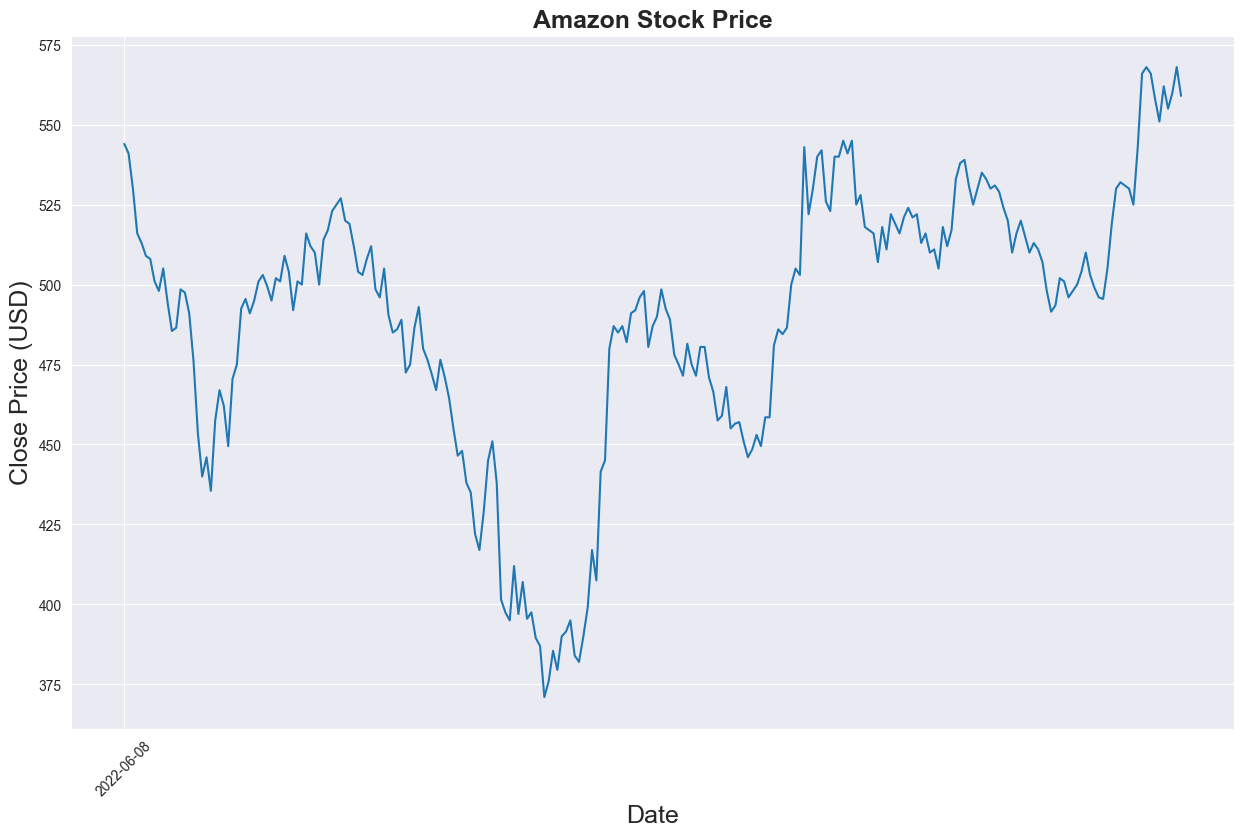

In [918]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

## Normalize data

In [919]:
price = data[['Close']]
price = data.loc[:,['Close','High','Volume']]

price.info()
# data.loc[:,['Close','High']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   245 non-null    float64
 1   High    245 non-null    float64
 2   Volume  245 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 5.9 KB


In [920]:
price['Close'][-30:]

215    493.5
216    502.0
217    501.0
218    496.0
219    498.0
220    500.0
221    504.0
222    510.0
223    503.0
224    499.0
225    496.0
226    495.5
227    505.0
228    519.0
229    530.0
230    532.0
231    531.0
232    530.0
233    525.0
234    543.0
235    566.0
236    568.0
237    566.0
238    558.0
239    551.0
240    562.0
241    555.0
242    560.0
243    568.0
244    559.0
Name: Close, dtype: float64

In [921]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price['High'] = scaler.fit_transform(price['High'].values.reshape(-1,1))
price['Volume'] = scaler.fit_transform(price['Volume'].values.reshape(-1,1))



In [922]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [923]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (180, 19, 3)
y_train.shape =  (180, 3)
x_test.shape =  (45, 19, 3)
y_test.shape =  (45, 3)


In [924]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [925]:
input_dim = 1
input_dim = 3
hidden_dim = 32
hidden_dim = 50
num_layers = 5
output_dim = 1
num_epochs = 100

In [926]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [927]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [928]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([180, 3])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch  0 MSE:  0.27184000611305237
Epoch  1 MSE:  0.25413715839385986
Epoch  2 MSE:  0.25150564312934875
Epoch  3 MSE:  0.25146496295928955
Epoch  4 MSE:  0.2503396272659302
Epoch  5 MSE:  0.24768075346946716
Epoch  6 MSE:  0.23950254917144775
Epoch  7 MSE:  0.23429924249649048
Epoch  8 MSE:  0.2346462905406952
Epoch  9 MSE:  0.2244371920824051
Epoch  10 MSE:  0.2254624366760254
Epoch  11 MSE:  0.22055304050445557
Epoch  12 MSE:  0.20954786241054535
Epoch  13 MSE:  0.20508147776126862
Epoch  14 MSE:  0.207237109541893
Epoch  15 MSE:  0.20124118030071259
Epoch  16 MSE:  0.1988137662410736
Epoch  17 MSE:  0.20203222334384918
Epoch  18 MSE:  0.19675840437412262
Epoch  19 MSE:  0.19345112144947052
Epoch  20 MSE:  0.19798533618450165
Epoch  21 MSE:  0.192053884267807
Epoch  22 MSE:  0.19142451882362366
Epoch  23 MSE:  0.1938047558069229
Epoch  24 MSE:  0.19222736358642578
Epoch  25 MSE:  0.18994511663913727
Epoch  26 MSE:  0.1892777532339096
Epoch  27 MSE:  0.19072893261909485
Epoch  28 MSE

In [929]:
y_train_pred.detach()

tensor([[-0.2737],
        [-0.3012],
        [-0.3638],
        [-0.3016],
        [-0.2565],
        [-0.2762],
        [-0.3309],
        [-0.2082],
        [-0.1853],
        [-0.0024],
        [ 0.0260],
        [-0.0120],
        [ 0.0230],
        [ 0.0066],
        [ 0.0195],
        [-0.0143],
        [-0.0454],
        [-0.0482],
        [-0.0064],
        [ 0.0244],
        [ 0.0188],
        [-0.0096],
        [-0.0203],
        [-0.0244],
        [ 0.0491],
        [ 0.0500],
        [ 0.0460],
        [-0.0036],
        [ 0.0253],
        [ 0.0457],
        [ 0.0867],
        [ 0.1112],
        [ 0.1366],
        [ 0.1076],
        [ 0.0842],
        [ 0.0350],
        [-0.0118],
        [-0.0446],
        [-0.0531],
        [-0.0300],
        [-0.0477],
        [-0.0679],
        [-0.0151],
        [-0.0442],
        [-0.0905],
        [-0.1388],
        [-0.1466],
        [-0.1883],
        [-0.2116],
        [-0.1673],
        [-0.1335],
        [-0.1661],
        [-0.

In [930]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

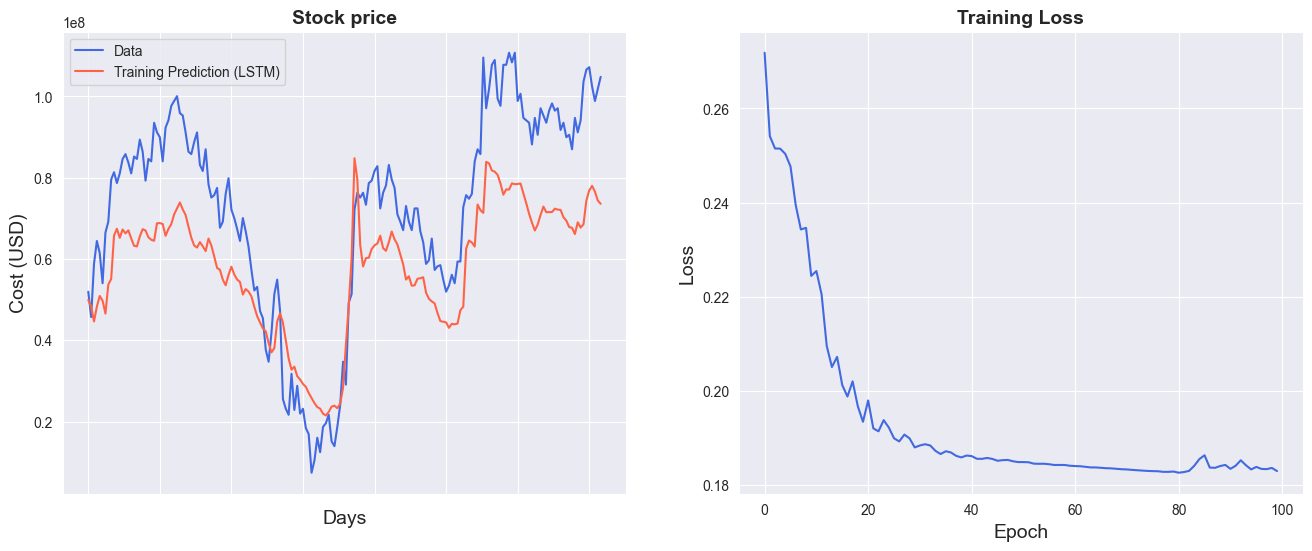

In [931]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [932]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 18215961.53 RMSE
Test Score: 26121942.55 RMSE


In [933]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [934]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [935]:
# !pip install chart-studio
fig.show()

In [936]:
import chart_studio.plotly as py
import chart_studio

chart_studio.tools.set_credentials_file(username='cheney1003', api_key='Wje635GLnIztnQSPCTrS')
py.iplot(fig, filename='stock_prediction_lstm')

In [937]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [938]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [939]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

C:\Users\sulab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([180, 3])) that is different to the input size (torch.Size([180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch  0 MSE:  0.27775225043296814
Epoch  1 MSE:  0.3913567364215851
Epoch  2 MSE:  0.26054441928863525
Epoch  3 MSE:  0.24624678492546082
Epoch  4 MSE:  0.23171895742416382
Epoch  5 MSE:  0.21587903797626495
Epoch  6 MSE:  0.20772017538547516
Epoch  7 MSE:  0.20048624277114868
Epoch  8 MSE:  0.21048513054847717
Epoch  9 MSE:  0.19189278781414032
Epoch  10 MSE:  0.20719759166240692
Epoch  11 MSE:  0.19046537578105927
Epoch  12 MSE:  0.19967052340507507
Epoch  13 MSE:  0.19405658543109894
Epoch  14 MSE:  0.18912406265735626
Epoch  15 MSE:  0.1939201056957245
Epoch  16 MSE:  0.1903700977563858
Epoch  17 MSE:  0.1882442682981491
Epoch  18 MSE:  0.19078615307807922
Epoch  19 MSE:  0.19065353274345398
Epoch  20 MSE:  0.18764333426952362
Epoch  21 MSE:  0.18737751245498657
Epoch  22 MSE:  0.189078688621521
Epoch  23 MSE:  0.18766988813877106
Epoch  24 MSE:  0.18656213581562042
Epoch  25 MSE:  0.18733708560466766
Epoch  26 MSE:  0.18784409761428833
Epoch  27 MSE:  0.1868475079536438
Epoch  28

In [940]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

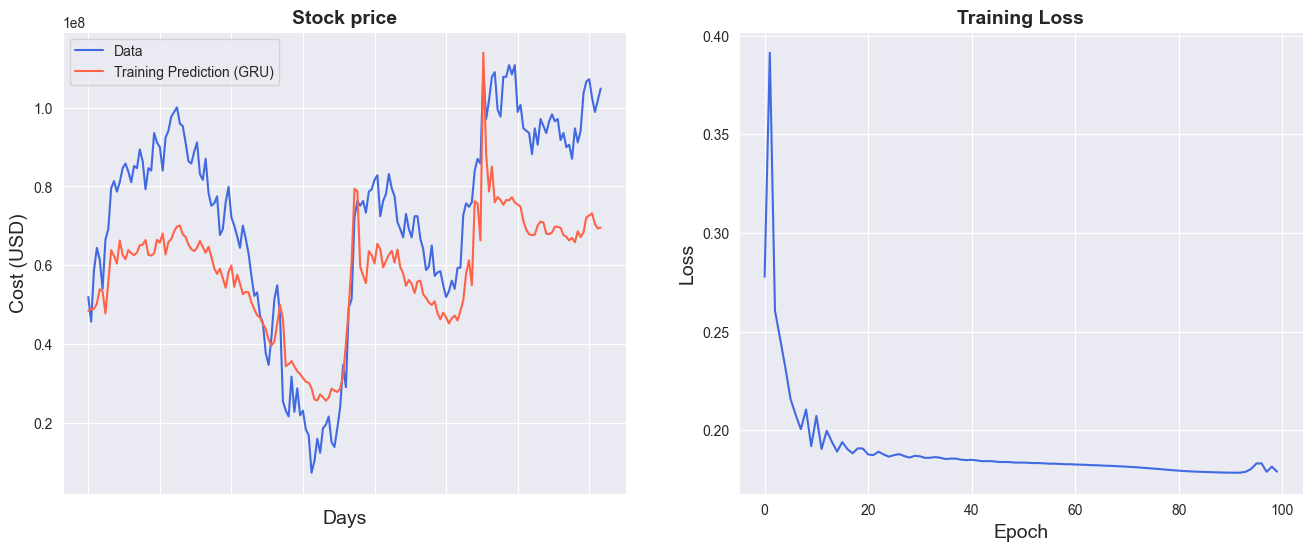

In [941]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [942]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

Train Score: 19093035.54 RMSE
Test Score: 32790852.83 RMSE


In [943]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [944]:
testPredictPlot

array([[      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,       nan],
       [      nan,       nan,     

In [945]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[3],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[4],
                    mode='lines',
                    name='Actual Value')))
# fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=original,
#                     mode='lines',
#                     name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [946]:
# lstm = pd.DataFrame(lstm, columns=['LSTM'])
# gru = pd.DataFrame(gru, columns=['GRU'])
# result = pd.concat([lstm, gru], axis=1, join='inner')
# result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
# result

In [947]:
py.iplot(fig, filename='stock_prediction_gru')

In [948]:
y_test_pred = model(x_test)
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_pred

x_fuck = x_test[-1:]
y_fuck_pred = model(x_fuck)
y_fuck_pred = scaler.inverse_transform(y_fuck_pred.detach().numpy())
y_fuck_pred

y_fuck_pred

array([[76144152.]], dtype=float32)